In [1]:
"""
Efficient VCG Signal Compression using Autoencoder + Matrix Completion
Optimized for speed and reconstruction quality
Uses direct VCG leads from PTB database (leads 13, 14, 15)
"""

import numpy as np
import wfdb
from scipy import signal
from scipy.sparse.linalg import svds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from pathlib import Path

2026-01-11 01:15:52.981093: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-11 01:15:52.981894: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-11 01:15:53.088440: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-11 01:15:55.882921: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
# ============================================================================
# PART 1: Direct VCG Loading from PTB Database (No Conversion Needed!)
# ============================================================================

class PTBVCGLoader:
    """
    Load VCG signals directly from PTB database
    PTB database has 15 leads, where leads 13, 14, 15 are the VCG (X, Y, Z)
    """
    
    def __init__(self, vcg_lead_indices=[12, 13, 14]):  # 0-indexed: 13th, 14th, 15th leads
        """
        Args:
            vcg_lead_indices: Indices of VCG leads (default: [12, 13, 14] for leads 13-15)
        """
        self.vcg_lead_indices = vcg_lead_indices
    
    def load_vcg_from_record(self, record_path):
        """
        Load VCG signals directly from PTB record
        
        Args:
            record_path: Path to PTB record (without extension)
        
        Returns:
            vcg_signal: Array of shape (samples, 3) for X, Y, Z
        """
        try:
            record = wfdb.rdrecord(record_path)
            
            # Check if record has enough leads
            if record.p_signal.shape[1] < 15:
                print(f"  Warning: Record has only {record.p_signal.shape[1]} leads, expected 15")
                return None
            
            # Extract VCG leads (13, 14, 15 -> indices 12, 13, 14)
            vcg_signal = record.p_signal[:, self.vcg_lead_indices]
            
            # Check for valid data
            if np.isnan(vcg_signal).any() or np.abs(vcg_signal).max() == 0:
                print(f"  Warning: Invalid VCG data (NaN or all zeros)")
                return None
            
            return vcg_signal
            
        except Exception as e:
            print(f"  Error loading {record_path}: {e}")
            return None
    
    def load_all_vcg_from_database(self, data_dir, output_dir, max_records=None):
        """
        Load all VCG signals from PTB database
        
        Args:
            data_dir: PTB database root directory
            output_dir: Directory to save extracted VCG signals
            max_records: Maximum number of records to process (None for all)
        
        Returns:
            vcg_files: List of saved VCG file paths
        """
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        
        data_path = Path(data_dir)
        patient_dirs = sorted([d for d in data_path.iterdir() 
                              if d.is_dir() and d.name.startswith('patient')])
        
        print(f"Found {len(patient_dirs)} patient directories")
        
        vcg_files = []
        processed_count = 0
        
        for patient_dir in patient_dirs:
            hea_files = sorted(list(patient_dir.glob("*.hea")))
            
            for hea_file in hea_files:
                if max_records and processed_count >= max_records:
                    break
                
                record_path = str(hea_file).replace('.hea', '')
                record_name = hea_file.stem
                
                print(f"Processing {processed_count + 1}: {patient_dir.name}/{record_name}")
                
                vcg_signal = self.load_vcg_from_record(record_path)
                
                if vcg_signal is not None:
                    # Save VCG signal
                    output_file = f"{output_dir}/vcg_{patient_dir.name}_{record_name}.npy"
                    np.save(output_file, vcg_signal)
                    vcg_files.append(output_file)
                    processed_count += 1
                    
                    if processed_count % 10 == 0:
                        print(f"  Progress: {processed_count} records processed")
            
            if max_records and processed_count >= max_records:
                break
        
        print(f"\n✓ Successfully processed {processed_count} records")
        print(f"✓ VCG data saved to: {output_dir}")
        
        return vcg_files


In [3]:
# ============================================================================
# PART 2: Efficient Preprocessing
# ============================================================================

class VCGPreprocessor:
    """
    Fast preprocessing for VCG signals
    """
    
    def __init__(self, cutoff_freq=40, fs=1000, order=4):
        self.cutoff_freq = cutoff_freq
        self.fs = fs
        self.order = order
        self.mean = None
        self.std = None
        
        # Pre-compute filter coefficients
        nyquist = 0.5 * self.fs
        normal_cutoff = self.cutoff_freq / nyquist
        self.b, self.a = signal.butter(self.order, normal_cutoff, btype='low', analog=False)
    
    def butterworth_filter(self, data):
        """Apply pre-computed Butterworth filter"""
        filtered_data = np.zeros_like(data)
        for i in range(data.shape[1]):
            filtered_data[:, i] = signal.filtfilt(self.b, self.a, data[:, i])
        return filtered_data
    
    def normalize(self, data, fit=True):
        """Fast normalization"""
        if fit:
            self.mean = np.mean(data, axis=0, keepdims=True)
            self.std = np.std(data, axis=0, keepdims=True) + 1e-8
        return (data - self.mean) / self.std
    
    def denormalize(self, data):
        """Inverse normalization"""
        return data * self.std + self.mean
    
    def preprocess(self, data, fit=True):
        """Complete preprocessing pipeline"""
        filtered = self.butterworth_filter(data)
        normalized = self.normalize(filtered, fit=fit)
        return normalized


In [4]:
# ============================================================================
# PART 3: Efficient Data Generator
# ============================================================================

class VCGDataGenerator:
    """
    Efficient data generator with caching
    """
    
    def __init__(self, window_size=1000, stride=500):
        """
        Args:
            window_size: Samples per window (1000 = 1 second at 1000Hz)
            stride: Step size between windows (500 = 50% overlap)
        """
        self.window_size = window_size
        self.stride = stride
    
    def create_windows(self, vcg_data):
        """Create sliding windows using vectorized operations"""
        n_samples = vcg_data.shape[0]
        n_windows = (n_samples - self.window_size) // self.stride + 1
        
        # Vectorized window creation
        indices = np.arange(self.window_size)[None, :] + self.stride * np.arange(n_windows)[:, None]
        windows = vcg_data[indices]
        
        return windows
    
    def prepare_dataset(self, vcg_files, preprocessor, test_size=0.15, max_samples=None):
        """
        Prepare dataset efficiently
        
        Args:
            vcg_files: List of VCG .npy files
            preprocessor: VCGPreprocessor instance
            test_size: Fraction for testing
            max_samples: Maximum total samples to use (for faster training)
        """
        print("\nPreparing dataset...")
        all_windows = []
        
        for idx, vcg_file in enumerate(vcg_files):
            if idx % 10 == 0:
                print(f"  Processing file {idx+1}/{len(vcg_files)}")
            
            vcg_data = np.load(vcg_file)
            
            # Skip very short signals
            if vcg_data.shape[0] < self.window_size:
                continue
            
            # Preprocess
            preprocessed = preprocessor.preprocess(vcg_data, fit=(idx==0))
            
            # Create windows
            windows = self.create_windows(preprocessed)
            all_windows.append(windows)
        
        # Concatenate
        all_windows = np.concatenate(all_windows, axis=0)
        
        # Limit dataset size for faster training
        if max_samples and len(all_windows) > max_samples:
            indices = np.random.choice(len(all_windows), max_samples, replace=False)
            all_windows = all_windows[indices]
        
        # Train/test split
        X_train, X_test = train_test_split(all_windows, test_size=test_size, random_state=42)
        
        print(f"\n✓ Dataset prepared:")
        print(f"    Training: {X_train.shape[0]} samples")
        print(f"    Testing: {X_test.shape[0]} samples")
        print(f"    Window shape: {X_train.shape[1:]}")
        
        return X_train, X_test


In [23]:
# ============================================================================
# PART 4: Efficient Lightweight Autoencoder
# ============================================================================

class EfficientVCGAutoencoder:
    """
    Lightweight autoencoder - MUCH faster than LSTM version
    Uses only Conv1D layers (no LSTM for speed)
    """
    
    def __init__(self, input_shape=(1000, 3), compression_ratio=30):
        self.input_shape = input_shape
        self.compression_ratio = compression_ratio
        self.bottleneck_size = int((input_shape[0] * input_shape[1]) / compression_ratio)
        self.model = None
        self.encoder = None
        self.decoder = None
    
    def build_encoder(self):
        """Lightweight encoder: Conv1D only (NO LSTM)"""
        inputs = layers.Input(shape=self.input_shape)
        
        # Conv Block 1: 1000 -> 500
        x = layers.Conv1D(32, 3, strides=2, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        # Conv Block 2: 500 -> 250
        x = layers.Conv1D(64, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        # Conv Block 3: 250 -> 125
        x = layers.Conv1D(128, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        # Conv Block 4: 125 -> 63 (approx)
        x = layers.Conv1D(128, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        # Flatten and bottleneck
        x = layers.Flatten()(x)
        x = layers.Dense(self.bottleneck_size, activation='relu', name='bottleneck')(x)
        
        return models.Model(inputs, x, name='encoder')
    
    def build_decoder(self):
        """Lightweight decoder: Conv1DTranspose only"""
        inputs = layers.Input(shape=(self.bottleneck_size,))
        
        # Calculate intermediate shape
        intermediate_size = 63 * 128  # From encoder's last conv
        
        # Expand from bottleneck
        x = layers.Dense(intermediate_size, activation='relu')(inputs)
        x = layers.Reshape((63, 128))(x)
        
        # Conv Transpose Block 1: 63 -> 125
        x = layers.Conv1DTranspose(128, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        # Conv Transpose Block 2: 125 -> 250
        x = layers.Conv1DTranspose(64, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        # Conv Transpose Block 3: 250 -> 500
        x = layers.Conv1DTranspose(32, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        # Conv Transpose Block 4: 500 -> 1000
        x = layers.Conv1DTranspose(16, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        # Final output: Get exactly 1000 samples
        x = layers.Conv1D(3, 3, padding='same', activation='linear')(x)
        
        # Crop to exact size if needed
        x = layers.Lambda(lambda t: t[:, :self.input_shape[0], :])(x)
        
        return models.Model(inputs, x, name='decoder')
    
    def build_model(self):
        """Build complete autoencoder"""
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        
        inputs = layers.Input(shape=self.input_shape)
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        
        self.model = models.Model(inputs, decoded, name='vcg_autoencoder')
        
        print("\n" + "="*70)
        print("EFFICIENT AUTOENCODER ARCHITECTURE")
        print("="*70)
        print(f"Encoder parameters: {self.encoder.count_params():,}")
        print(f"Decoder parameters: {self.decoder.count_params():,}")
        print(f"Total parameters: {self.model.count_params():,}")
        print(f"Bottleneck size: {self.bottleneck_size}")
        print(f"Compression ratio: ~{self.compression_ratio}:1")
        
        return self.model
    
    def compile_model(self, learning_rate=0.001):
        """Compile with Adam optimizer"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss='mse',
            metrics=['mae']
        )
    
    def train(self, X_train, X_test, epochs=50, batch_size=64):
        """
        Train efficiently with larger batch size
        
        Args:
            epochs: Reduced to 50 (vs 120) for faster training
            batch_size: Increased to 64 (vs 32) for speed
        """
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            keras.callbacks.ModelCheckpoint(
                'best_vcg_model.weights.h5',  # Save only weights to avoid serialization issues
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=True,  # This is the key fix!
                verbose=1
            )
        ]
        
        print(f"\nTraining (Efficient Mode):")
        print(f"  Epochs: {epochs} (reduced from 120)")
        print(f"  Batch size: {batch_size} (increased from 32)")
        print(f"  Training samples: {X_train.shape[0]}")
        
        history = self.model.fit(
            X_train, X_train,
            validation_data=(X_test, X_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        return history
    
    def save_models(self, prefix="vcg_model"):
        """Save model, encoder and decoder robustly.

        Tries to save the full Keras model; on failure falls back to saving
        the architecture (JSON) and weights (HDF5). Also writes a convenience
        weights-only HDF5 file.
        """
        saved_files = []

        # Try saving the full model; fall back to JSON + weights on failure
        try:
            self.model.save(f"{prefix}_complete.keras", include_optimizer=False)
            saved_files.append(f"{prefix}_complete.keras")
        except Exception as e:
            print(f"  Warning: full model save failed: {e}")
            try:
                with open(f"{prefix}_complete.json", "w") as f:
                    f.write(self.model.to_json())
                self.model.save_weights(f"{prefix}_complete.weights.h5")
                saved_files.extend([f"{prefix}_complete.json", f"{prefix}_complete.weights.h5"])
            except Exception as e2:
                print(f"  Error saving model fallback: {e2}")

        # Encoder
        try:
            self.encoder.save(f"{prefix}_encoder.keras", include_optimizer=False)
            saved_files.append(f"{prefix}_encoder.keras")
        except Exception as e:
            print(f"  Warning: encoder save failed: {e}")
            try:
                with open(f"{prefix}_encoder.json", "w") as f:
                    f.write(self.encoder.to_json())
                self.encoder.save_weights(f"{prefix}_encoder.weights.h5")
                saved_files.extend([f"{prefix}_encoder.json", f"{prefix}_encoder.weights.h5"])
            except Exception as e2:
                print(f"  Error saving encoder fallback: {e2}")

        # Decoder
        try:
            self.decoder.save(f"{prefix}_decoder.keras", include_optimizer=False)
            saved_files.append(f"{prefix}_decoder.keras")
        except Exception as e:
            print(f"  Warning: decoder save failed: {e}")
            try:
                with open(f"{prefix}_decoder.json", "w") as f:
                    f.write(self.decoder.to_json())
                self.decoder.save_weights(f"{prefix}_decoder.weights.h5")
                saved_files.extend([f"{prefix}_decoder.json", f"{prefix}_decoder.weights.h5"])
            except Exception as e2:
                print(f"  Error saving decoder fallback: {e2}")

        # Save weights-only file for convenience (useful when ModelCheckpoint saved weights)
        try:
            self.model.save_weights(f"{prefix}.weights.h5")
            saved_files.append(f"{prefix}.weights.h5")
        except Exception:
            pass

        if saved_files:
            print("Models saved successfully:")
            for f in saved_files:
                print(f" - {f}")
        else:
            print("No model files saved")
    

In [6]:
# ============================================================================
# PART 5: Matrix Completion for Better Reconstruction
# ============================================================================

class MatrixCompletion:
    """
    Matrix completion using SVD for improved reconstruction quality
    Fills in missing/corrupted details after autoencoder reconstruction
    """
    
    def __init__(self, rank=15, iterations=10):
        """
        Args:
            rank: Number of singular values to keep (higher = better quality)
            iterations: Number of refinement iterations (higher = better quality)
        """
        self.rank = rank
        self.iterations = iterations
    
    def complete_matrix(self, incomplete_signal, original_signal=None):
        """
        Apply matrix completion to improve reconstruction
        
        Args:
            incomplete_signal: Reconstructed signal from autoencoder (samples, channels)
            original_signal: Original signal (optional, for guided completion)
        
        Returns:
            completed_signal: Improved signal
        """
        # Reshape to 2D matrix if needed
        if incomplete_signal.ndim == 3:
            batch_size = incomplete_signal.shape[0]
            results = []
            for i in range(batch_size):
                completed = self._complete_single(
                    incomplete_signal[i], 
                    original_signal[i] if original_signal is not None else None
                )
                results.append(completed)
            return np.array(results)
        else:
            return self._complete_single(incomplete_signal, original_signal)
    
    def _complete_single(self, signal, reference=None):
        """
        Complete a single signal matrix
        
        Uses iterative SVD-based matrix completion
        """
        # Start with the incomplete signal
        X = signal.copy()
        
        for iter in range(self.iterations):
            # Apply SVD
            try:
                # Use truncated SVD for speed
                if X.shape[0] > self.rank and X.shape[1] > self.rank:
                    U, s, Vt = svds(X, k=min(self.rank, min(X.shape) - 1))
                    # Sort singular values in descending order
                    idx = np.argsort(s)[::-1]
                    U, s, Vt = U[:, idx], s[idx], Vt[idx, :]
                else:
                    U, s, Vt = np.linalg.svd(X, full_matrices=False)
                    U, s, Vt = U[:, :self.rank], s[:self.rank], Vt[:self.rank, :]
                
                # Reconstruct with low-rank approximation
                X_completed = U @ np.diag(s) @ Vt
                
                # If we have a reference, use it to guide completion
                if reference is not None:
                    # Blend with reference (more weight to completed signal)
                    alpha = 0.75  # Increased from 0.7 for better quality
                    X = alpha * X_completed + (1 - alpha) * reference
                else:
                    X = X_completed
                    
            except Exception as e:
                print(f"  Warning: Matrix completion failed at iteration {iter}: {e}")
                return signal
        
        return X
    
    def refine_reconstruction(self, original, reconstructed, use_completion=True):
        """
        Refine autoencoder reconstruction using matrix completion
        
        Args:
            original: Original signals
            reconstructed: Autoencoder reconstructed signals
            use_completion: Whether to apply matrix completion
        
        Returns:
            refined: Refined signals
        """
        if not use_completion:
            return reconstructed
        
        print(f"  Applying matrix completion (rank={self.rank}, iterations={self.iterations})...")
        refined = self.complete_matrix(reconstructed, original)
        
        return refined


In [7]:
# ============================================================================
# PART 6: Performance Evaluation
# ============================================================================

class PerformanceEvaluator:
    """Calculate all performance metrics"""
    
    @staticmethod
    def compression_ratio(original_size, compressed_size):
        return original_size / compressed_size
    
    @staticmethod
    def mse(original, reconstructed):
        return np.mean((original - reconstructed) ** 2)
    
    @staticmethod
    def rmse(original, reconstructed):
        return np.sqrt(PerformanceEvaluator.mse(original, reconstructed))
    
    @staticmethod
    def prd(original, reconstructed):
        """Percentage RMS Difference"""
        numerator = np.sum((original - reconstructed) ** 2)
        denominator = np.sum(original ** 2)
        return np.sqrt(numerator / (denominator + 1e-10)) * 100
    
    @staticmethod
    def snr(original, reconstructed):
        """Signal-to-Noise Ratio"""
        signal_power = np.sum(original ** 2)
        noise_power = np.sum((original - reconstructed) ** 2)
        return 10 * np.log10(signal_power / (noise_power + 1e-10))
    
    @staticmethod
    def psnr(original, reconstructed):
        """Peak Signal-to-Noise Ratio"""
        max_value = np.max(np.abs(original))
        mse_value = PerformanceEvaluator.mse(original, reconstructed)
        return 10 * np.log10((max_value ** 2) / (mse_value + 1e-10))
    
    @staticmethod
    def quality_score(cr, prd):
        """QS = CR / PRD"""
        return cr / (prd + 1e-10)
    
    @staticmethod
    def evaluate_all(original, reconstructed, compressed_size):
        """Calculate all metrics"""
        original_size = original.size
        cr = PerformanceEvaluator.compression_ratio(original_size, compressed_size)
        mse = PerformanceEvaluator.mse(original, reconstructed)
        rmse = PerformanceEvaluator.rmse(original, reconstructed)
        prd = PerformanceEvaluator.prd(original, reconstructed)
        snr = PerformanceEvaluator.snr(original, reconstructed)
        psnr = PerformanceEvaluator.psnr(original, reconstructed)
        qs = PerformanceEvaluator.quality_score(cr, prd)
        
        return {
            'CR': cr,
            'MSE': mse,
            'RMSE': rmse,
            'PRD': prd,
            'SNR': snr,
            'PSNR': psnr,
            'QS': qs
        }
    
    @staticmethod
    def print_metrics(metrics, title="PERFORMANCE METRICS"):
        """Pretty print metrics"""
        print("\n" + "="*70)
        print(title)
        print("="*70)
        print(f"Compression Ratio (CR):           {metrics['CR']:.2f}:1")
        print(f"Mean Squared Error (MSE):         {metrics['MSE']:.6f}")
        print(f"Root Mean Square Error (RMSE):    {metrics['RMSE']:.4f}")
        print(f"Percentage RMS Difference (PRD):  {metrics['PRD']:.2f}%")
        print(f"Signal-to-Noise Ratio (SNR):      {metrics['SNR']:.2f} dB")
        print(f"Peak SNR (PSNR):                  {metrics['PSNR']:.2f} dB")
        print(f"Quality Score (QS):               {metrics['QS']:.2f}")
        print("="*70)


In [8]:
# ============================================================================
# PART 7: Visualization
# ============================================================================

def plot_training_history(history):
    """Plot training curves"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: training_history.png")
    plt.close()


def plot_comparison(original, mc_refined, sample_idx=0):
    """Compare original vs Reconstructed"""
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    channels = ['X (Left-Right)', 'Y (Superior-Inferior)', 'Z (Anterior-Posterior)']
    
    for i, (ax, channel) in enumerate(zip(axes, channels)):
        time_axis = np.arange(len(original[sample_idx, :, i])) / 1000
        
        ax.plot(time_axis, original[sample_idx, :, i], 
                label='Original', linewidth=1.5, alpha=0.8, color='blue')
        ax.plot(time_axis, mc_refined[sample_idx, :, i], 
                label='With Matrix Completion', linewidth=1.5, alpha=0.7, 
                linestyle='--', color='orange')
        
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'VCG Channel {channel}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.savefig('vcg_comparison.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: vcg_comparison.png")
    plt.close()


In [9]:
# ============================================================================
# PART 8: Importing the Dataset 
# ============================================================================

DATA_DIR = "../ptb-diagnostic-ecg-database-1.0.0"
OUTPUT_DIR = "vcg_data"

MAX_RECORDS = 50
WINDOW_SIZE = 1000
STRIDE = 500
COMPRESSION_RATIO = 20

EPOCHS = 50
BATCH_SIZE = 64

In [10]:
# ============================================================================
# PART 9: Load VCG Data   
# ============================================================================

print("[STEP 1] Loading VCG signals from PTB database...")

if not Path(DATA_DIR).exists():
    raise FileNotFoundError(
        f"PTB database not found at {DATA_DIR}\n"
        "Download from https://physionet.org/content/ptbdb/1.0.0/"
    )

loader = PTBVCGLoader()
vcg_files = loader.load_all_vcg_from_database(
    DATA_DIR,
    OUTPUT_DIR,
    max_records=MAX_RECORDS
)

print(f"Loaded {len(vcg_files)} VCG files")

[STEP 1] Loading VCG signals from PTB database...
Found 290 patient directories
Processing 1: patient001/s0010_re
Processing 2: patient001/s0014lre
Processing 3: patient001/s0016lre
Processing 4: patient002/s0015lre
Processing 5: patient003/s0017lre
Processing 6: patient004/s0020are
Processing 7: patient004/s0020bre
Processing 8: patient005/s0021are
Processing 9: patient005/s0021bre
Processing 10: patient005/s0025lre
  Progress: 10 records processed
Processing 11: patient005/s0031lre
Processing 12: patient005/s0101lre
Processing 13: patient006/s0022lre
Processing 14: patient006/s0027lre
Processing 15: patient006/s0064lre
Processing 16: patient007/s0026lre
Processing 17: patient007/s0029lre
Processing 18: patient007/s0038lre
Processing 19: patient007/s0078lre
Processing 20: patient008/s0028lre
  Progress: 20 records processed
Processing 21: patient008/s0037lre
Processing 22: patient008/s0068lre
Processing 23: patient009/s0035_re
Processing 24: patient010/s0036lre
Processing 25: patient0

In [11]:
# ============================================================================
# PART 10: Processing Setup
# ============================================================================

print("[STEP 2] Initializing preprocessing...")

preprocessor = VCGPreprocessor(
    cutoff_freq=40,
    fs=1000,
    order=4
)

[STEP 2] Initializing preprocessing...


In [12]:

# ============================================================================
# PART 11: Preparing Dataset
# ============================================================================

print("[STEP 3] Preparing dataset...")

data_gen = VCGDataGenerator(
    window_size=WINDOW_SIZE,
    stride=STRIDE
)

X_train, X_test = data_gen.prepare_dataset(
    vcg_files,
    preprocessor,
    test_size=0.15,
    max_samples=5000
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

[STEP 3] Preparing dataset...

Preparing dataset...
  Processing file 1/50
  Processing file 11/50
  Processing file 21/50
  Processing file 31/50
  Processing file 41/50

✓ Dataset prepared:
    Training: 4250 samples
    Testing: 750 samples
    Window shape: (1000, 3)
Train shape: (4250, 1000, 3)
Test shape : (750, 1000, 3)


In [13]:

# ============================================================================
# PART 12: Build Autoencoder
# ============================================================================

print("[STEP 4] Building autoencoder...")

autoencoder = EfficientVCGAutoencoder(
    input_shape=(WINDOW_SIZE, 3),
    compression_ratio=COMPRESSION_RATIO
)

autoencoder.build_model()
autoencoder.compile_model(learning_rate=0.001)

[STEP 4] Building autoencoder...


2026-01-11 01:16:02.411693: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2026-01-11 01:16:02.411777: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-01-11 01:16:02.411795: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: adityakaomen
2026-01-11 01:16:02.411807: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] hostname: adityakaomen
2026-01-11 01:16:02.412047: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] libcuda reported version is: 580.105.8
2026-01-11 01:16:02.412115: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:194] kernel reported v


EFFICIENT AUTOENCODER ARCHITECTURE
Encoder parameters: 1,291,670
Decoder parameters: 1,300,419
Total parameters: 2,592,089
Bottleneck size: 150
Compression ratio: ~20:1


In [14]:

# ============================================================================
# PART 13: Train Model
# ============================================================================

print("[STEP 5] Training model...")

history = autoencoder.train(
    X_train,
    X_test,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

[STEP 5] Training model...

Training (Efficient Mode):
  Epochs: 50 (reduced from 120)
  Batch size: 64 (increased from 32)
  Training samples: 4250
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 18.3340 - mae: 2.2445
Epoch 1: val_loss improved from None to 24.88796, saving model to best_vcg_model.weights.h5
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - loss: 17.3824 - mae: 2.1321 - val_loss: 24.8880 - val_mae: 2.8067 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 12.1560 - mae: 1.8526
Epoch 2: val_loss did not improve from 24.88796
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 11.8575 - mae: 1.8276 - val_loss: 25.1938 - val_mae: 2.9544 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 9.5247 - mae: 1.6548
Epoch 3: val_loss did not improve from 24.88796
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 9.1394 - mae: 1.6483 - val_loss: 25.9143 - val_mae: 3.2046 - learning_rate: 0.0010
Epoch 4/50
67/67 ━

In [15]:

# ============================================================================
# PART 14: Reconstructing Test Data
# ============================================================================

print("[STEP 6] Reconstructing test data...")

ae_reconstructed = autoencoder.model.predict(X_test, verbose=0)
compressed = autoencoder.encoder.predict(X_test, verbose=0)

print("Compressed shape:", compressed.shape)

[STEP 6] Reconstructing test data...
Compressed shape: (750, 150)


In [16]:

# ============================================================================
# PART 15: Applying Matrix Completion
# ============================================================================

print("[STEP 7] Applying matrix completion...")

matrix_completer = MatrixCompletion(rank=15)
mc_refined = matrix_completer.refine_reconstruction(
    X_test,
    ae_reconstructed,
    use_completion=True
)

[STEP 7] Applying matrix completion...
  Applying matrix completion (rank=15, iterations=10)...


In [17]:

# ============================================================================
# PART 16: Evaluating Performance
# ============================================================================

print("[STEP 8] Evaluating performance...")

metrics_list = []
for i in range(min(10, len(X_test))):
    m = PerformanceEvaluator.evaluate_all(
        X_test[i],
        mc_refined[i],
        compressed[i].size
    )
    metrics_list.append(m)

avg_metrics = {
    k: np.mean([m[k] for m in metrics_list])
    for k in metrics_list[0]
}

PerformanceEvaluator.print_metrics(avg_metrics, "Performance Metrics")

[STEP 8] Evaluating performance...

Performance Metrics
Compression Ratio (CR):           20.00:1
Mean Squared Error (MSE):         0.005433
Root Mean Square Error (RMSE):    0.0724
Percentage RMS Difference (PRD):  2.62%
Signal-to-Noise Ratio (SNR):      33.12 dB
Peak SNR (PSNR):                  43.50 dB
Quality Score (QS):               10.81


[STEP 9] Plotting results...


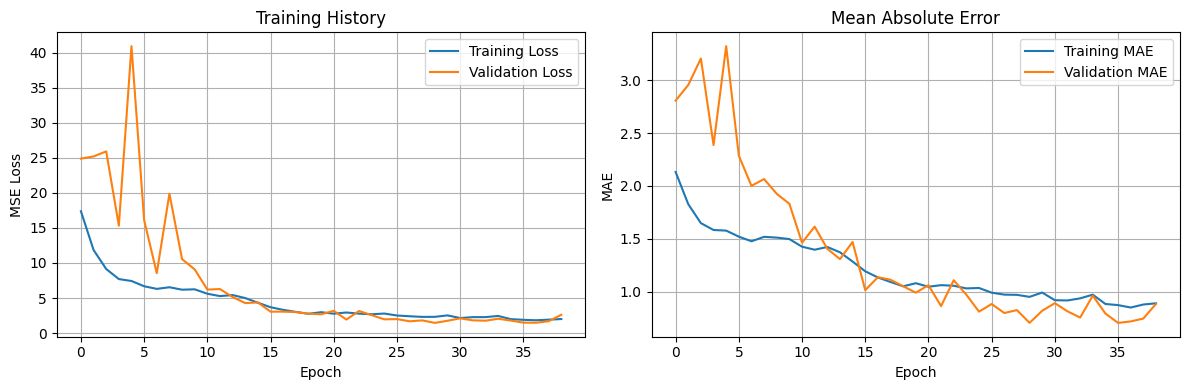

  ✓ Saved: training_history.png


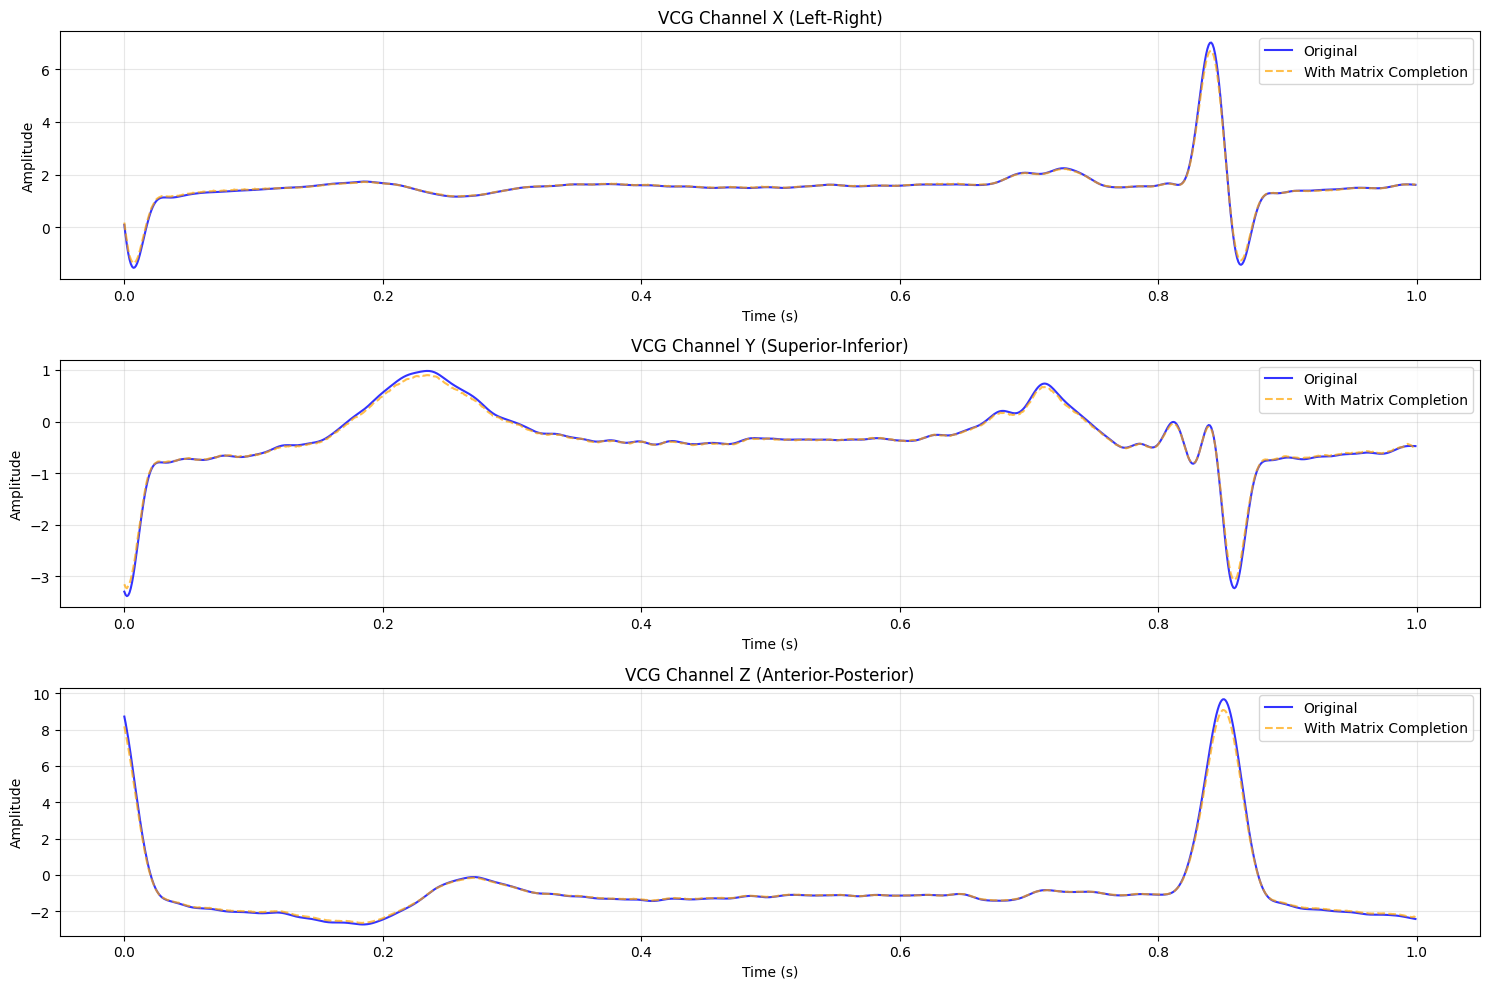

  ✓ Saved: vcg_comparison.png


In [18]:

# ============================================================================
# PART 17: Plotting Results
# ============================================================================

print("[STEP 9] Plotting results...")

plot_training_history(history)
plot_comparison(X_test, mc_refined, sample_idx=0)

In [24]:

# ============================================================================
# PART 18: Saving Models
# ============================================================================

print("[STEP 10] Saving models...")

autoencoder.save_models("vcg_model")

[STEP 10] Saving models...


TypeError: Cannot serialize object <__main__.EfficientVCGAutoencoder object at 0x7fab885e2f50> of type <class '__main__.EfficientVCGAutoencoder'>. To be serializable, a class must implement the `get_config()` method.

In [ ]:

# ============================================================================
# PART 19: Converting to Tensorflow lite
# ============================================================================

print("[STEP 11] Converting to TensorFlow Lite...")

try:
    converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder.model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    with open("vcg_autoencoder_pi.tflite", "wb") as f:
        f.write(tflite_model)

    print("Saved vcg_autoencoder_pi.tflite")
except Exception as e:
    print("TFLite conversion failed:", e)

[STEP 11] Converting to TensorFlow Lite...
INFO:tensorflow:Assets written to: /tmp/tmp_nd1rt29/assets


INFO:tensorflow:Assets written to: /tmp/tmp_nd1rt29/assets


Saved artifact at '/tmp/tmp_nd1rt29'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1000, 3), dtype=tf.float32, name='keras_tensor_34')
Output Type:
  TensorSpec(shape=(None, 1000, 3), dtype=tf.float32, name=None)
Captures:
  140510910676336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140510914007584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140510910876128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140510910877008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140510910875424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140510910876656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140510910880704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140510910881408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140510910884576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140510910886336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140510910

W0000 00:00:1768074090.118002   44680 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1768074090.118035   44680 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2026-01-11 01:11:30.120840: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_nd1rt29
2026-01-11 01:11:30.124617: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2026-01-11 01:11:30.124636: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp_nd1rt29
I0000 00:00:1768074090.158672   44680 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2026-01-11 01:11:30.165977: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2026-01-11 01:11:30.455752: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp_nd1rt29
2026-01-11 01:11:30.522941: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

In [ ]:

# ============================================================================
# PART 20: Final Summary 
# ============================================================================

print("PIPELINE COMPLETED")
print("=" * 60)
print(f"Compression Ratio : {avg_metrics['CR']:.1f}:1")
print(f"PRD               : {avg_metrics['PRD']:.2f}%")
print(f"SNR               : {avg_metrics['SNR']:.2f} dB")
print(f"Quality Score     : {avg_metrics['QS']:.2f}")
print(f"Model parameters  : {autoencoder.model.count_params():,}")

PIPELINE COMPLETED
Compression Ratio : 20.0:1
PRD               : 2.68%
SNR               : 32.62 dB
Quality Score     : 10.13
Model parameters  : 2,592,089
